In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import datetime as dt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import random
import pprint
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### Reading data from preprocessed file.

In [2]:
data = pd.read_csv('data/prepocessed.csv', encoding='utf8', engine='python')
data = data.drop(data.columns[0], axis=1)
states = data.State.unique()

#### Creating separate files of timeseries for each state.

In [3]:
for state in states:
    filename = "state Data/"+state + ".csv"
    datatemp = data.loc[data['State'] == state]
    datatemp = datatemp.groupby(['Date Local']).mean().reset_index()
    datatemp = datatemp[['Date Local','NO2 Mean']].copy()
    datatemp.to_csv(filename, ',', encoding='utf8')

#### creating list of timeseries', later to be fed in algorithm

In [3]:
timeSeriesList = []
j=0
for state in states:
    filename = "state Data/"+state+".csv"
    datatemp = pd.read_csv(filename, usecols=['NO2 Mean'])
    dataList = datatemp['NO2 Mean'].tolist()
    seriesNP = np.asarray(dataList)
    timeSeriesList.append(dataList[0:200])
    j=j+1
finaltimeSeriesList = np.asarray(timeSeriesList)

#### Dynamic Time Wrapping & LB_Keogh for lower bounding of DTW

In [4]:
def DynamicTimeWarping(ts1, ts2, window):
    DTW_Dictionary={}
    
    window = max(window, abs(len(ts1)-len(ts2)))
    
    for i in range(-1,len(ts1)):
        for j in range(-1,len(ts2)):
            DTW_Dictionary[(i, j)] = float('inf')
    DTW_Dictionary[(-1, -1)] = 0
  
    for item in range(len(ts1)):
        for j in range(max(0, item-window), min(len(ts2), item+window)):
            distance= (ts1[item]-ts2[j])**2
            DTW_Dictionary[(item, j)] = distance + min(DTW_Dictionary[(item-1, j)],DTW_Dictionary[(item, j-1)], DTW_Dictionary[(item-1, j-1)])
        
    return np.sqrt(DTW_Dictionary[len(ts1)-1, len(ts2)-1])


def LowerBoundKeogh(ts1,ts2,reach):
    lowerBoundSum=0
    for index, item in enumerate(ts1):
        if len(ts2[(index-reach if index-reach>=0 else 0):(index+reach)])==0:
            break
        lowerBound = min(ts2[(index-reach if index-reach>=0 else 0):(index+reach)])
        upperBound = max(ts2[(index-reach if index-reach>=0 else 0):(index+reach)])
        
        if item>upperBound:
            lowerBoundSum = lowerBoundSum+(item-upperBound)**2
        elif item<lowerBound:
            lowerBoundSum = lowerBoundSum+(item-lowerBound)**2
    
    return np.sqrt(lowerBoundSum)

#### K-Means Clustering. Args - Data, number of clusters, number of iterations, window for DynamicTimeWarping

In [5]:
def KMeans(data, numCluster, iterations, window):
    centroids = random.sample(list(data),numCluster)

    for n in range(iterations):
        print(n)
        clusterID = {}
        
        for index, item in enumerate(data):
            minDist = float('inf')
            closestCluster = None
            for centroidIndex, j in enumerate(centroids):
                if LowerBoundKeogh(item, j, 5) < minDist:
                    currentDist = DynamicTimeWarping(item, j, window)
                    if currentDist < minDist:
                        minDist = currentDist
                        closestCluster = centroidIndex
                       
            if closestCluster in clusterID:
                clusterID[closestCluster].append(index)
            else:
                clusterID[closestCluster]=[]

        for ID in clusterID:
            clusterSum = [0]*200
            if ID is not None:
                for k in clusterID[ID]:
                    clusterSum = clusterSum + data[k]   
                centroids[ID] = [m/len(clusterID[ID]) for m in clusterSum if len(clusterID[ID])!=0]
    
    return centroids, clusterID

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


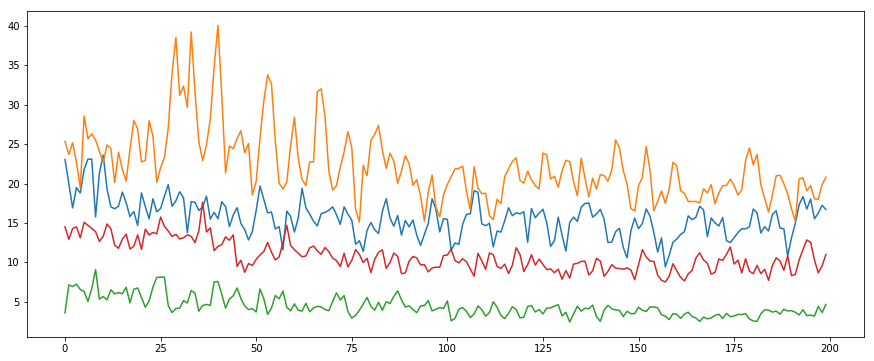

In [6]:
centroids, clusterID = KMeans(finaltimeSeriesList, 4, 20, 5)

for i in centroids:
    plt.plot(i)
    
plt.show()

#### Results of clustering state-wise

In [7]:
dictionary = {}
for i in clusterID:
    list = clusterID[i]
    tempList = []
    for state in list:
        tempList.append(states[state])
    dictionary[i] = tempList
pprint.pprint(dictionary)

{0: ['Indiana',
     'Louisiana',
     'Missouri',
     'North Carolina',
     'Texas',
     'Connecticut',
     'Wisconsin',
     'Georgia',
     'Utah',
     'Alaska'],
 1: ['District Of Columbia',
     'Illinois',
     'Michigan',
     'New Jersey',
     'New York',
     'Pennsylvania',
     'Virginia',
     'Massachusetts',
     'Country Of Mexico'],
 2: ['Nevada',
     'Tennessee',
     'South Carolina',
     'Iowa',
     'Maine',
     'Wyoming',
     'North Dakota',
     'Ohio',
     'Hawaii',
     'Minnesota',
     'Rhode Island',
     'South Dakota'],
 3: ['Florida',
     'Kansas',
     'Kentucky',
     'New Hampshire',
     'Maryland',
     'Arkansas',
     'Oregon',
     'Idaho',
     'Delaware',
     'New Mexico',
     'Alabama',
     'Washington']}


#### Converting cluster centroids into time-series

In [8]:
base = dt.datetime(2000, 1, 1, 0, 0, 0)
datelist = pd.date_range(base, periods=200).tolist()

cluster1 = pd.DataFrame({'Date':datelist, 'NO2 Mean':centroids[0]})
cluster1['Date'] = pd.to_datetime(cluster1['Date'], format='%Y-%m-%d')


cluster2 = pd.DataFrame({'Date':datelist, 'NO2 Mean':centroids[1]})
cluster2['Date'] = pd.to_datetime(cluster2['Date'], format='%Y-%m-%d')

cluster3 = pd.DataFrame({'Date':datelist, 'NO2 Mean':centroids[2]})
cluster3['Date'] = pd.to_datetime(cluster3['Date'], format='%Y-%m-%d')

cluster4 = pd.DataFrame({'Date':datelist, 'NO2 Mean':centroids[3]})
cluster4['Date'] = pd.to_datetime(cluster4['Date'], format='%Y-%m-%d')

cluster1TS = cluster1.set_index('Date')
cluster2TS = cluster2.set_index('Date')
cluster3TS = cluster3.set_index('Date')
cluster4TS = cluster4.set_index('Date')

#### Generating graph for each clusters

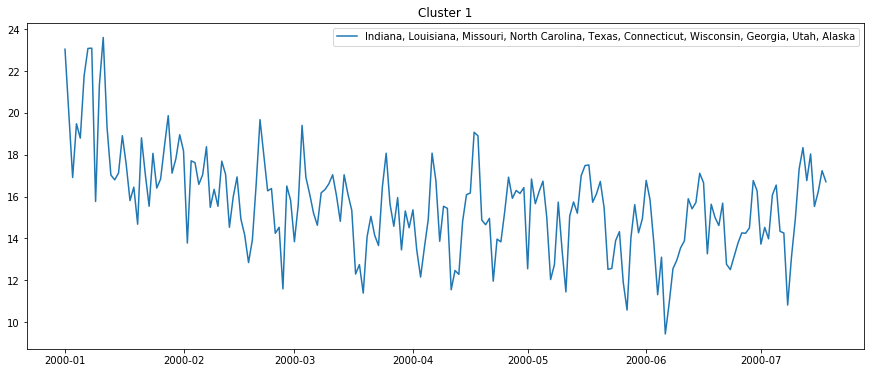

In [9]:
label=", ".join(str(x) for x in dictionary[0])
plt.plot(cluster1TS, label=label)
plt.legend(loc="best")
plt.title("Cluster 1")
plt.show(block=False)

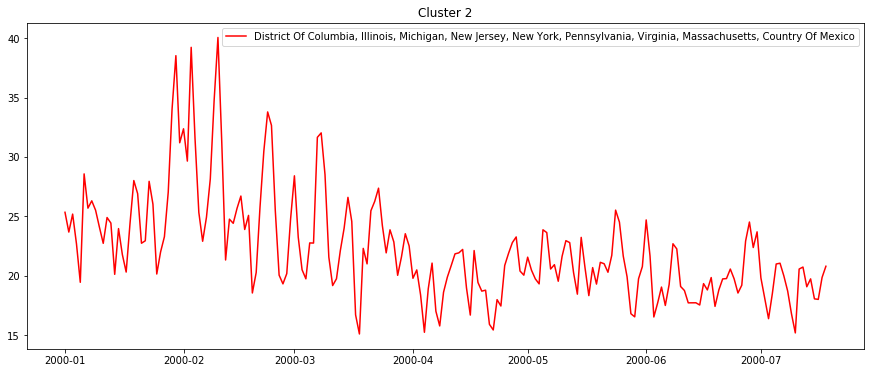

In [10]:
label=", ".join(str(x) for x in dictionary[1])
plt.plot(cluster2TS, label=label, color='red')
plt.legend(loc="best")
plt.title("Cluster 2")
plt.show(block=False)

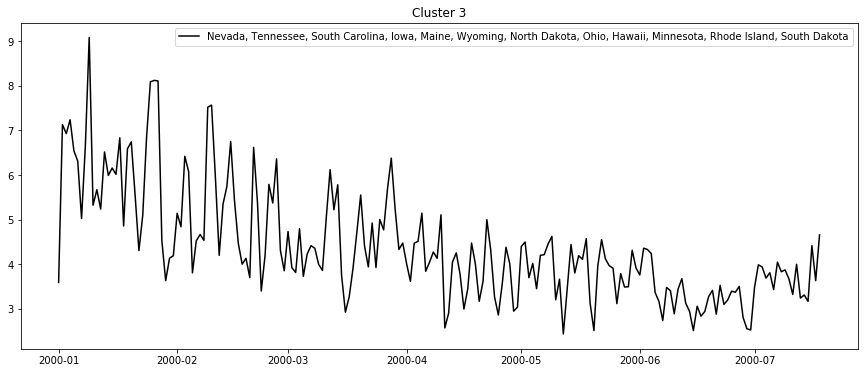

In [11]:
label=", ".join(str(x) for x in dictionary[2])
plt.plot(cluster3TS, label=label, color='black')
plt.legend(loc="best")
plt.title("Cluster 3")
plt.show(block=False)

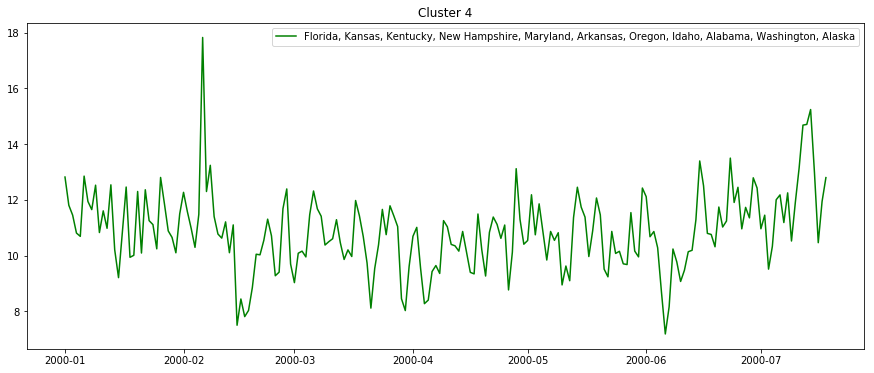

In [22]:
label=", ".join(str(x) for x in dictionary[3])
plt.plot(cluster4TS, label=label, color='green')
plt.legend(loc="best")
plt.title("Cluster 4")
plt.show(block=False)

#### ARIMA on cluster 1

In [12]:
cluster1Values = cluster1TS.values
train, test = cluster1Values[0:int(len(cluster1Values) * 0.80)], cluster1Values[int(len(cluster1Values) * 0.80):len(cluster1Values)]
trainingData = [x for x in train]
predictions = []

for item in range(len(test)):
    model = ARIMA(trainingData, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    predicted = output[0]
    predictions.append(predicted)
    observation = test[item]
    trainingData.append(observation)
    print('predicted=%f, expected=%f' % (predicted, observation))

predicted=12.321344, expected=12.950952
predicted=11.686289, expected=13.547203
predicted=13.276011, expected=13.883234
predicted=12.939755, expected=15.894402
predicted=14.610982, expected=15.413331
predicted=14.536235, expected=15.711991
predicted=15.246268, expected=17.111907
predicted=16.405128, expected=16.661075
predicted=15.868427, expected=13.261810
predicted=14.236813, expected=15.630566
predicted=16.066580, expected=15.000713
predicted=14.606271, expected=14.612560
predicted=14.782119, expected=15.682967
predicted=15.946037, expected=12.761867
predicted=12.963044, expected=12.504583
predicted=13.574532, expected=13.140090
predicted=13.416175, expected=13.769960
predicted=13.322588, expected=14.260652
predicted=14.141400, expected=14.241630
predicted=13.856154, expected=14.498219
predicted=14.109653, expected=16.764206
predicted=15.745776, expected=16.274143
predicted=15.391626, expected=13.723796
predicted=14.262149, expected=14.523194
predicted=15.060406, expected=13.978106


Test MSE: 2.657


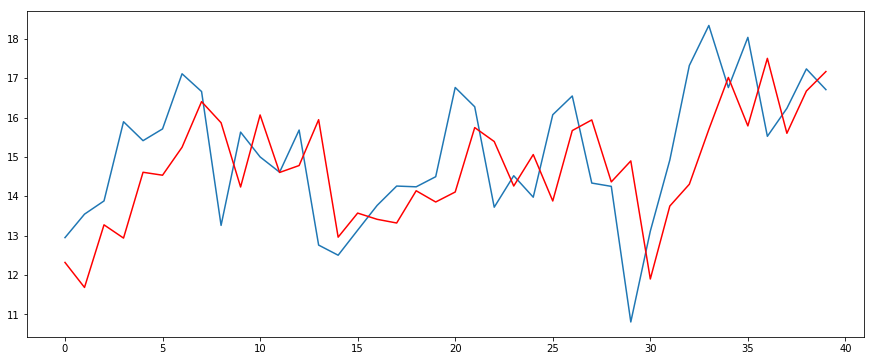

In [13]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [14]:
intraClusterError = {}
interDistance = 0

for j in clusterID.keys():
    distance = 0
    for i in clusterID[j]:
        temp = finaltimeSeriesList[j][0:200]
        tempCentroid = centroids[j]
        distance = distance + DynamicTimeWarping(temp, tempCentroid, 5)
    intraClusterError[j] = distance
    
intraDistance = sum(intraClusterError.values())

for i in range(4):
    for j in range(i+1,4):
        interDistance = interDistance + DynamicTimeWarping(centroids[i], centroids[j], 5)
        
variance = interDistance + intraDistance

print('Intra Cluster Distance: %.3f' % intraDistance)
print('Inter Cluster Distance: %.3f' % interDistance)
print('Total Sum Square (Variance): %.3f' % variance)


Intra Cluster Distance: 7615.394
Inter Cluster Distance: 834.990
Total Sum Square (Variance): 8450.384
